<a href="https://colab.research.google.com/github/PolinaTiugaeva/mfdp/blob/main/baseline_game_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импорты библиотек
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Описание проекта
Сервис для подбора видеоигр позволяет искать игры по произвольному запросу, а результаты поиска ранжирует в соответствии с предпочтениями пользователя. Для поиска игр используются векторные БД. В ноутбуке представлен baseline рекомендательной системы, которую можно использовать для переранжирования результатов поиска.

# **Чтение данных и EDA**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Чтение датасета с рекомендациями
df_rec = pd.read_csv("/content/drive/MyDrive/recommendations.csv", low_memory=False)
df_rec.shape

(41154794, 8)

In [4]:
df_rec.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [5]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


In [6]:
df_rec.describe()

,app_id,helpful,funny,hours,user_id,review_id
count,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07
mean,6.032724e+05,3.202567e+00,1.058071e+00,1.006022e+02,7.450576e+06,2.057740e+07
std,4.729233e+05,4.693649e+01,2.867060e+01,1.761675e+02,4.010685e+06,1.188037e+07
min,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.539400e+05,0.000000e+00,0.000000e+00,7.800000e+00,4.287256e+06,1.028870e+07
50%,4.351500e+05,0.000000e+00,0.000000e+00,2.730000e+01,7.546446e+06,2.057740e+07
75%,9.331100e+05,0.000000e+00,0.000000e+00,9.920000e+01,1.096877e+07,3.086609e+07
max,2.253290e+06,3.621200e+04,2.810900e+04,1.000000e+03,1.430606e+07,4.115479e+07


In [7]:
print(f"Количество пустых значений user_id = {df_rec['user_id'].isna().sum()}")
print(f"Количество пустых значений app_id = {df_rec['app_id'].isna().sum()}")
print(f"Количество пустых значений is_recommended = {df_rec['is_recommended'].isna().sum()}")
print(f"Количество пустых значений date = {df_rec['date'].isna().sum()}")

Количество пустых значений user_id = 0
Количество пустых значений app_id = 0
Количество пустых значений is_recommended = 0
Количество пустых значений date = 0


In [8]:
df_rec['date'] = pd.to_datetime(df_rec['date'])

In [9]:
# Преобразование даты рекомендации в колонки год, месяц, день недели
df_rec['year'] = df_rec['date'].apply(lambda x: x.year)
df_rec.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,year
0,975370,0,0,2022-12-12,True,36.3,51580,0,2022
1,304390,4,0,2017-02-17,False,11.5,2586,1,2017
2,1085660,2,0,2019-11-17,True,336.5,253880,2,2019
3,703080,0,0,2022-09-23,True,27.4,259432,3,2022
4,526870,0,0,2021-01-10,True,7.9,23869,4,2021


In [10]:
df_rec['month'] = df_rec['date'].apply(lambda x: x.month)
df_rec.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,year,month
0,975370,0,0,2022-12-12,True,36.3,51580,0,2022,12
1,304390,4,0,2017-02-17,False,11.5,2586,1,2017,2
2,1085660,2,0,2019-11-17,True,336.5,253880,2,2019,11
3,703080,0,0,2022-09-23,True,27.4,259432,3,2022,9
4,526870,0,0,2021-01-10,True,7.9,23869,4,2021,1


In [11]:
df_rec['dayofweek'] = df_rec['date'].apply(lambda x: x.dayofweek)
df_rec.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,year,month,dayofweek
0,975370,0,0,2022-12-12,True,36.3,51580,0,2022,12,0
1,304390,4,0,2017-02-17,False,11.5,2586,1,2017,2,4
2,1085660,2,0,2019-11-17,True,336.5,253880,2,2019,11,6
3,703080,0,0,2022-09-23,True,27.4,259432,3,2022,9,4
4,526870,0,0,2021-01-10,True,7.9,23869,4,2021,1,6


In [12]:
# Количество уникальных пользователей
df_rec['user_id'].nunique()

13781059

In [13]:
# Количество уникальных приложений
df_rec['app_id'].nunique()

37610

In [14]:
# Соотношение классов
df_rec['is_recommended'].value_counts()

,count
is_recommended,
True,35304398
False,5850396


* В датасете преобладают положительные отзывы на игры

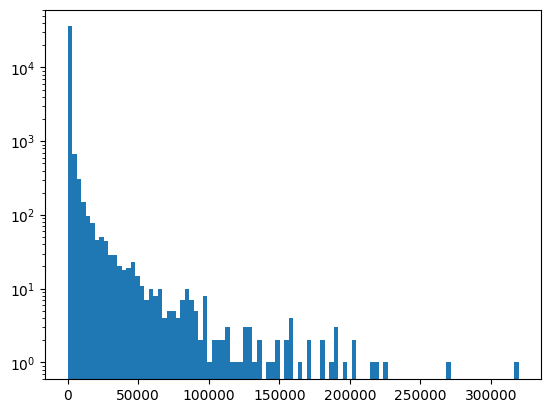

In [15]:
plt.hist(df_rec.groupby("app_id")["is_recommended"].count(), log=True, bins=100)
plt.show()

Как видно на гистограме, количество оценок пользователей различается для некоторых игр. Большинство игр имеют небольшое количество оценок (до 1000). При этом есть единичные игры, количесство оценок у которых превышает это значение.

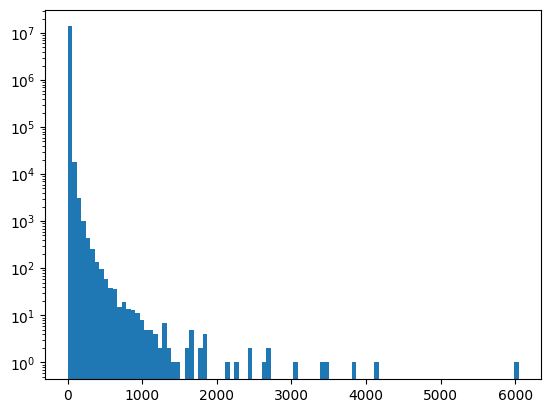

In [16]:
plt.hist(df_rec.groupby("user_id")["is_recommended"].count(), log=True, bins=100)
plt.show()

Как видно на гистограмме, большинство пользователей не часто рекомендуют игры. И есть небольшое количество пользователей, которые рекомендуют игры активно.

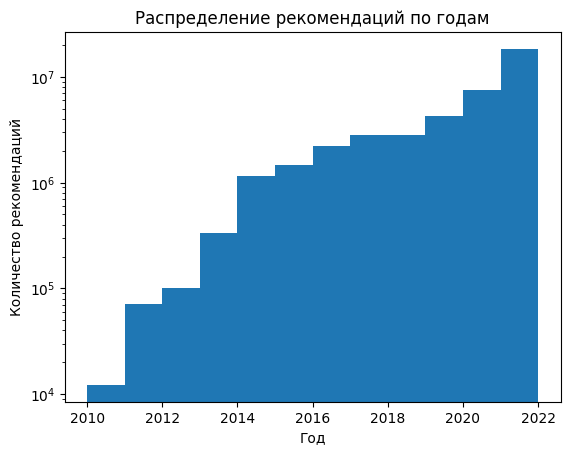

In [17]:
# Распределение рекомендаций по годам
plt.hist(df_rec['year'], bins=12, log=True)
plt.title('Распределение рекомендаций по годам')
plt.xlabel('Год')
plt.ylabel('Количество рекомендаций')
plt.show()

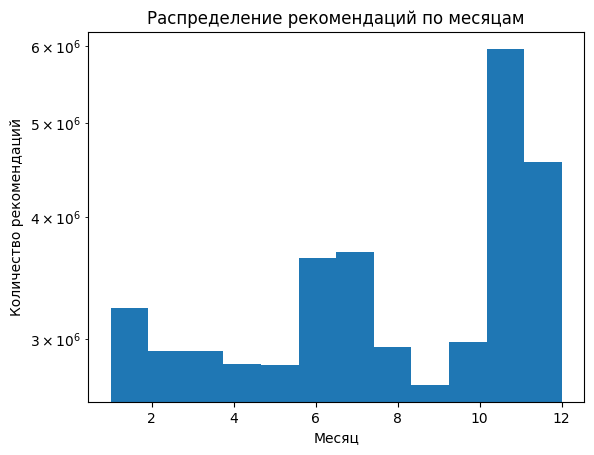

In [18]:
# Распределение рекомендаций по месяцам
plt.hist(df_rec['month'], bins=12, log=True)
plt.title('Распределение рекомендаций по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество рекомендаций')
plt.show()

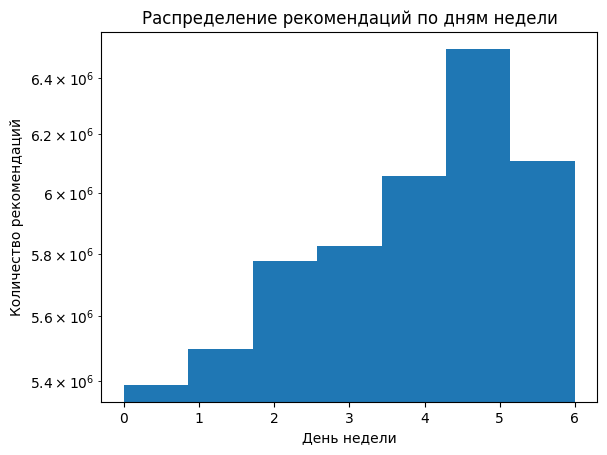

In [19]:
# Распределение рекомендаций по дням недели
plt.hist(df_rec['dayofweek'], bins=7, log=True)
plt.title('Распределение рекомендаций по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество рекомендаций')
plt.show()

In [20]:
# Для обучения и валидации удаляю из датасета пользователей, у которых мало положительных рекомендаций
df_rec = df_rec[df_rec['is_recommended'] == True]
user_id = df_rec.groupby('user_id')['is_recommended'].count()
user_id = user_id[user_id > 5]
user_id


,is_recommended
user_id,
0,11
14,6
36,10
58,9
76,8
...,...
14305989,7
14306001,6
14306002,10


In [21]:
df_rec = df_rec[df_rec['user_id'].isin(user_id.index)]
df_rec.shape

(16113763, 11)

In [22]:

# Для обучения и валидации ставлю только положительные рекомендации за декабрь 2022 года
df_rec = df_rec[(df_rec['month'] == 12) & (df_rec['year'] == 2022)]
df_rec.shape

(301199, 11)

In [23]:
df_rec['user_id'].nunique()

182152

In [24]:
df_rec['app_id'].nunique()

13682

# **Baseline рекомендательной системы**

В качестве baseline можно рассмотреть следующие варианты рекомендаций:
1. Рекомендация самых популярных игр
1. User-based коллаборотивная фильтрация

In [25]:
# Для обучения и валидации оставляю колонки
# 'app_id', 'user_id', 'is_recommended','date'
df_rec = df_rec.loc[:,['app_id', 'user_id', 'is_recommended','date']]
df_rec.describe()

,app_id,user_id,date
count,3.011990e+05,3.011990e+05,301199
mean,9.574882e+05,7.149957e+06,2022-12-16 18:04:45.347560704
min,1.000000e+01,3.600000e+01,2022-12-01 00:00:00
25%,3.933800e+05,3.485790e+06,2022-12-09 00:00:00
50%,9.753700e+05,7.197930e+06,2022-12-17 00:00:00
75%,1.447430e+06,1.079862e+07,2022-12-25 00:00:00
max,2.253290e+06,1.430600e+07,2022-12-31 00:00:00
std,6.107853e+05,4.166511e+06,NaN


In [26]:
# Разделение выборки на train и test по времени

rec_test, rec_train = df_rec[df_rec.date >= df_rec['date'].quantile(q=0.8)], df_rec[df_rec.date < df_rec['date'].quantile(q=0.8)]

In [27]:
rec_train = rec_train.drop('date', axis=1)
rec_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240841 entries, 59 to 41154667
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   app_id          240841 non-null  int64
 1   user_id         240841 non-null  int64
 2   is_recommended  240841 non-null  bool 
dtypes: bool(1), int64(2)
memory usage: 5.7 MB


In [28]:
rec_test = rec_test.drop('date', axis=1)
rec_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60358 entries, 23 to 41154764
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   app_id          60358 non-null  int64
 1   user_id         60358 non-null  int64
 2   is_recommended  60358 non-null  bool 
dtypes: bool(1), int64(2)
memory usage: 1.4 MB


In [29]:
# Для валидации коллаборативного подхода оставлю в train и test
# выборках пересечение user_id
arr1 = rec_train['user_id'].unique()
arr2 = rec_test['user_id'].unique()

common_user_id = np.intersect1d(arr1, arr2)
rec_train = rec_train[rec_train['user_id'].isin(common_user_id)]
rec_test = rec_test[rec_test['user_id'].isin(common_user_id)]


In [30]:
rec_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36975 entries, 514 to 41151612
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   app_id          36975 non-null  int64
 1   user_id         36975 non-null  int64
 2   is_recommended  36975 non-null  bool 
dtypes: bool(1), int64(2)
memory usage: 902.7 KB


In [31]:
rec_train['user_id'].nunique()

16414

In [32]:
rec_train['app_id'].nunique()

6851

In [33]:
rec_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23328 entries, 4485 to 41154764
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   app_id          23328 non-null  int64
 1   user_id         23328 non-null  int64
 2   is_recommended  23328 non-null  bool 
dtypes: bool(1), int64(2)
memory usage: 569.5 KB


## Рекомендация самых популярных игр

In [34]:
games_rate = rec_train.groupby('app_id')['is_recommended'].count().sort_values(ascending=False)
games_rate.head()

,is_recommended
app_id,
1544020,301
975370,266
1938090,242
2012840,209
1593500,205


In [35]:
# Подсчёт метрик - Precision, Recall
K = [10, 100, 1000]
for k in K:
    precision = []
    recall = []
    for user_id in common_user_id:
        rec = games_rate.iloc[:k].index
        y = rec_test[rec_test['user_id'] == user_id]['app_id']
        precision.append(len(y[y.isin(rec)])/k)
        if y.count() > 0:
          recall.append(len(y[y.isin(rec)])/y.count())

    print(f'K = {k}')
    print(f'Precision@{k} = {np.mean(precision)}')
    print(f'Recall@{k} = {np.mean(recall)}')

K = 10
Precision@10 = 0.00519069087364445
Recall@10 = 0.04143849292788638
K = 100
Precision@100 = 0.0036858779091019866
Recall@100 = 0.28307180008759913
K = 1000
Precision@1000 = 0.0009777628853417815
Recall@1000 = 0.7163931360410167


Рекомендация 1000 самых популярных игр уже дает высокий recall. Это объясняется тем, что популярные игр чаще нравятся пользователям и получают хорошие отзывы. Точность при этом очень низкая, что может быть связано с тем, что количество рекомендаций значительно превышает среднее количество понравившихся пользователям игр. Для повышения точности необходимо работать над ранжированием рекомендаций и сокращать размер выборки.

## User-based коллаборативная фильтрация

In [36]:
pivot_table = rec_train.pivot_table(index="user_id", columns="app_id", values="is_recommended")
pivot_table.shape

(16414, 6851)

In [37]:
pivot_table.head(5)

app_id,10,20,30,40,50,60,70,80,130,220,...,2235760,2235780,2237940,2237980,2239320,2240530,2240910,2241190,2242980,2245840
user_id,,,,,,,,,,,,,,,,,,,,,
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Заполнение пустых значений и негативных оценок "0", позитивных оценок - "1"
pivot_table.fillna(0, inplace=True)
#pivot_table = pivot_table.astype(bool).astype(int)
pivot_table = pivot_table.replace({False : -1, True : 1})
pivot_table.head()

app_id,10,20,30,40,50,60,70,80,130,220,...,2235760,2235780,2237940,2237980,2239320,2240530,2240910,2241190,2242980,2245840
user_id,,,,,,,,,,,,,,,,,,,,,
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Precision, Recall
K = [10, 100, 1000]
N = [10, 100, 1000]
for k in K:
  for n in N:
    precision = []
    recall = []
    knn = NearestNeighbors(metric="cosine", n_neighbors=n)
    knn.fit(pivot_table.values)
    indc_arr = knn.kneighbors(pivot_table.loc[rec_test['user_id'].unique()], return_distance=False)
    for indc in indc_arr:
        rec = pivot_table.iloc[indc.flatten()].mean(axis=0).sort_values(ascending=False)[:k].index
        y = rec_test[(rec_test['user_id'] == user_id) & (rec_test['is_recommended'] == True)]['app_id']
        precision.append(len(y[y.isin(rec)])/k)
        if y.count() > 0:
          recall.append(len(y[y.isin(rec)])/y.count())

    print(f'K = {k}, N = {n}')
    print(f'Precision@{k} = {np.mean(precision)}')
    print(f'Recall@{k} = {np.mean(recall)}')


K = 10, N = 10
Precision@10 = 0.00040209577190203485
Recall@10 = 0.004020957719020349
K = 10, N = 100
Precision@10 = 0.0003168027293773608
Recall@10 = 0.0031680272937736078
K = 10, N = 1000
Precision@10 = 0.0001401242841476788
Recall@10 = 0.001401242841476788
K = 100, N = 10
Precision@100 = 6.336054587547216e-05
Recall@100 = 0.0063360545875472156
K = 100, N = 100
Precision@100 = 0.00033020592177409534
Recall@100 = 0.033020592177409526
K = 100, N = 1000
Precision@100 = 3.6554161082003174e-05
Recall@100 = 0.0036554161082003166
K = 1000, N = 10
Precision@1000 = 6.336054587547216e-06
Recall@1000 = 0.0063360545875472156
K = 1000, N = 100
Precision@1000 = 9.455342999878154e-05
Recall@1000 = 0.09455342999878152
K = 1000, N = 1000
Precision@1000 = 0.00019178749847690996
Recall@1000 = 0.19178749847690996


Метрики коллаборативной фильтрации оказались ниже, чем рекомендация самых популярных игр. При увеличении количества соседей и рекомендаций возрастает Recall. Это связано с тем, что при увеличении числа соседей в выборку попадают более популярные ингры.
В дальнейшем, для повышения качества рекомендаций, можно попробовать модель матричной факторизации, что позволит учитывать признаки пользователей и игр.